# Set up and process metadata

In [1]:
import csv
import numpy as np
from dataclasses import dataclass
from sys import argv

@dataclass
class tax_result:
    species: str
    genus: str
    abund: float
    seq_abund: float


def get_spec_to_metadata(file_path):
    spec_to_metadata = {}
    with open(file_path, 'r') as f:
        csv_reader = csv.DictReader(f, delimiter='\t')
        for row in csv_reader:
            if row['gtdb_representative'] == 'y':
                spec = row['gtdb_taxonomy'].split(';')[-1]
                spec_to_metadata[spec] = row
            elif row['gtdb_taxonomy'].split(';')[-1] not in spec_to_metadata:
                spec = row['gtdb_taxonomy'].split(';')[-1]
                spec_to_metadata[spec] = row
    return spec_to_metadata

def read_ganon_file(file_path, species_name_to_spec_and_genus, spec_to_metadata):
    taxonomic_data = {}
    with open(file_path, 'r') as f:
        for line in f:
            spl = line.split('\t')
            if spl[0] == 'species':
                name = spl[3]
                num_seqs = float(spl[-2])
                spec = species_name_to_spec_and_genus[name]
                species = spec[1]
                genus = spec[0]
                abund = 0
                seq_abund = num_seqs
                taxonomic_data[species] = tax_result(species, genus, abund, seq_abund)
    total_seq = 0
    total_abund = 0
    for (species, data) in taxonomic_data.items():
        total_seq += data.seq_abund
        total_abund += data.seq_abund * float(spec_to_metadata[species]['genome_size'])
    for (species, data) in taxonomic_data.items():
        data.abund = data.seq_abund * float(spec_to_metadata[species]['genome_size']) / total_abund
        data.seq_abund = data.seq_abund / total_seq
    return taxonomic_data

def read_kraken_file(file_path, species_name_to_spec_and_genus, spec_to_metadata, cutoff):
    tax_data = {}
    with open(file_path, 'r') as f:
        csv_reader = csv.DictReader(f, delimiter='\t')
        for row in csv_reader:
            spec = row['name']
            species = species_name_to_spec_and_genus[spec][1]
            genus = species_name_to_spec_and_genus[spec][0]
            seq_abund = float(row['fraction_total_reads'])
            if seq_abund > cutoff:
                res = tax_result(species, genus, 0, seq_abund)
                tax_data[species] = res

    total_seq_abund = 0
    total_abund = 0
    for (species, data) in tax_data.items():
        total_seq_abund += data.seq_abund
        total_abund += data.seq_abund * float(spec_to_metadata[species]['genome_size'])
    for (species,data) in tax_data.items():
        data.abund = data.seq_abund * float(spec_to_metadata[species]['genome_size']) / total_abund
        data.seq_abund = data.seq_abund / total_seq_abund
    return tax_data  

def read_kmcp_file(file_path, species_name_to_spec_and_genus, spec_to_metadata):
    tax_data = {}
    with open(file_path, 'r') as f:
        csv_reader = csv.DictReader(f, delimiter='\t')
        for row in csv_reader:
            spec = row['taxname']
            species = species_name_to_spec_and_genus[spec][1]
            genus = species_name_to_spec_and_genus[spec][0]
            seq_abund = float(row['reads'])
            res = tax_result(species, genus, 0, seq_abund)
            tax_data[species] = res

    #print(tax_data)
    total_seq_abund = 0
    total_abund = 0
    for (species, data) in tax_data.items():
        total_seq_abund += data.seq_abund
        total_abund += data.seq_abund * float(spec_to_metadata[species]['genome_size']) 
    for (species,data) in tax_data.items():
        data.abund = data.seq_abund * float(spec_to_metadata[species]['genome_size']) / total_abund 
        data.seq_abund = data.seq_abund / total_seq_abund
        #print(data)
    return tax_data    
                
def read_bac_to_gtdb(file_path):
    ref_to_spec_and_genus = {}
    species_name_to_spec_and_genus = {}
    with open(file_path, 'r') as f:
        for line in f:
            spl = line.strip().split("\t")
            ref = spl[0][3:]
            spec_and_genus = spl[1].split(';')[-2:]
            ref_to_spec_and_genus[ref] = spec_and_genus
            spec_string = spl[1].split(';')[-1][3:]
            species_name_to_spec_and_genus[spec_string] = spec_and_genus
    return (ref_to_spec_and_genus,species_name_to_spec_and_genus)

def truth(file_path, spec_to_metadata, spec90 = False):
    taxonomic_data = dict()
    results = []
    with open(file_path, 'r') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for row in csv_reader:
            spl = row
            spec = spl[0].split(';')[-2:]
            seq_abund = float(spl[1])
            size = float(spec_to_metadata[spec[1]]['genome_size'])
            data = tax_result(spec[1], spec[0], size, seq_abund)
            if spec90:
                if len(results) >= 50:
                    break
            results.append(data)
    total_cov = 0
    total_seq = 0
    for r in results:
        total_cov += r.abund * r.seq_abund
        total_seq += r.seq_abund
    for r in results:
        r.abund = r.abund * r.seq_abund / total_cov
        #r.seq_abund = r.seq_abund / total_seq
        if r.species in taxonomic_data:
            #print(r.species)
            taxonomic_data[r.species].seq_abund += r.seq_abund 
            taxonomic_data[r.species].abund += r.abund 
        else:
            taxonomic_data[r.species] = r

    return taxonomic_data

def read_sylph(file_path, ref_to_spec):
    sample_to_taxonomic_data = dict()
    with open(file_path, 'r') as f:
        csv_reader = csv.DictReader(f, delimiter='\t')
        for row in csv_reader:
            spl = row
            query = row['Sample_file'].split('/')[-1].split('_')
            diff = int(query[0][-2:])
            it = int(query[1])
            if (diff,it) in sample_to_taxonomic_data:
                taxonomic_data = sample_to_taxonomic_data[(diff,it)]
            else:
                taxonomic_data = {}
                sample_to_taxonomic_data[(diff,it)] = taxonomic_data
            if 'Query_file' in row:
                ref = row['Query_file'].split('/')[-1].split('_genomic')[0][3:]
            else:
                ref = row['Genome_file'].split('/')[-1].split('_genomic')[0][3:]
            spec = ref_to_spec[ref]
            r = tax_result(spec[1],spec[0], float(row['Taxonomic_abundance'])/100, float(row['Sequence_abundance'])/100)
            taxonomic_data[spec[1]] = r
    return sample_to_taxonomic_data

def read_metaphlan(file_path, spec_to_metadata, r207_to_r89):
    taxonomic_data = dict()
    results = []
    with open(file_path, 'r') as f:
        for row in f:
            if 's__' in row:
                spl = row.split('\t')[0].split(';')[-2:]
                genus = spl[0]
                spec = spl[1]
                key = tuple([genus, spec])
                if key not in r207_to_r89:
                    print(spec)
                    continue
                r89 = r207_to_r89[key]
                r89_spec = r89[1]
                r89_genus = r89[0]
                abund = row.split('\t')[-1].rstrip()
                size = spec_to_metadata[r89_spec]['genome_size']
                data = tax_result(r89_spec, r89_genus, float(abund), float(size))
                results.append(data)

    total_cov = 0
    total_seq = 0
    for r in results:
        total_cov += r.abund
        total_seq += r.seq_abund * r.abund
    for r in results:
        r.seq_abund = r.abund * r.seq_abund / total_seq
        #r.seq_abund = r.seq_abund / total_seq
        if r.species in taxonomic_data:
            #print(r.species)
            taxonomic_data[r.species].seq_abund += r.seq_abund 
            taxonomic_data[r.species].abund += r.abund 
        else:
            taxonomic_data[r.species] = r
    #print(taxonomic_data)
    return taxonomic_data

def compare_to_truth(res, truth, debug = False):
    tp = 0
    fp = 0
    num_true = len(truth)
    num_pred = len(res)
    seq_abund_vec_res = []
    seq_abund_vec_truth = []

    genus_seq_abund_vec_res = []
    genus_seq_abund_vec_truth = []

    genus_to_abund_truth = dict()
    genus_to_abund_res = dict()
    for data in res.values():
        if data.genus not in genus_to_abund_res:
            genus_to_abund_res[data.genus] = data.seq_abund
        else:
            genus_to_abund_res[data.genus] += data.seq_abund
            
    for data in truth.values():
        if data.genus not in genus_to_abund_truth:
            genus_to_abund_truth[data.genus] = data.seq_abund
        else:
            genus_to_abund_truth[data.genus] += data.seq_abund        

    for (genus, abund) in genus_to_abund_truth.items():
        if genus not in genus_to_abund_res:
            genus_seq_abund_vec_truth.append(abund)
            genus_seq_abund_vec_res.append(0)
        else:
            genus_seq_abund_vec_truth.append(abund)
            genus_seq_abund_vec_res.append(genus_to_abund_res[genus])
    for (genus,abund) in genus_to_abund_res.items():
        if genus not in genus_to_abund_truth:
            genus_seq_abund_vec_res.append(abund)
            genus_seq_abund_vec_truth.append(0)
    
    for spec, data in truth.items():
        seq_abund_vec_truth.append(data.seq_abund)
        if spec in res:
            #if debug:
            #    print(truth[spec], res[spec])
            seq_abund_vec_res.append(res[spec].seq_abund)
            tp += 1
        else:
            #if debug:
            #    print(spec, data)
            seq_abund_vec_res.append(0)
            #fp += 1
    for spec, data in res.items():
        if spec not in truth:
            if debug:
                print(data)
            fp += 1
            seq_abund_vec_res.append(res[spec].seq_abund)
            seq_abund_vec_truth.append(0)

    #seq_abund_vec_truth = seq_abund_vec_truth / np.linalg.norm(seq_abund_vec_truth,1)
    #seq_abund_vec_res = seq_abund_vec_res / np.linalg.norm(seq_abund_vec_res,1)
    #genus_seq_abund_vec_truth = genus_seq_abund_vec_truth / np.linalg.norm(genus_seq_abund_vec_truth, 1)
    #genus_seq_abund_vec_res = genus_seq_abund_vec_res / np.linalg.norm(genus_seq_abund_vec_res,1)


    norm_seq_truth = seq_abund_vec_truth / np.linalg.norm(seq_abund_vec_truth,1)
    norm_seq_res = seq_abund_vec_res / np.linalg.norm(seq_abund_vec_res,1)
    genus_seq_abund_vec_truth = genus_seq_abund_vec_truth / np.linalg.norm(genus_seq_abund_vec_truth, 1)
    genus_seq_abund_vec_res = genus_seq_abund_vec_res / np.linalg.norm(genus_seq_abund_vec_res,1)
    
    l1_seqabund = np.sum(np.abs(np.array(seq_abund_vec_res) - np.array(seq_abund_vec_truth)))
    l1_genus_seqabund = np.sum(np.abs(np.array(genus_seq_abund_vec_truth) - np.array(genus_seq_abund_vec_res)))

    l1_seqabund_species = (np.sum(np.abs(np.array(norm_seq_truth) - np.array(norm_seq_res))))

    sensitivity = tp/num_true
    precision = 1 - fp/num_pred

    print('---------------')
    print("F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct")
    f1 = 2 / (1 / sensitivity + 1 / precision)
    print(f1, l1_seqabund, l1_genus_seqabund, sensitivity, precision, num_pred, tp)
    return({"f1":f1, "l1":l1_seqabund, "sensitivity": sensitivity, "precision": precision,
            "num_pred": num_pred, "tp": tp, "l1genus": l1_genus_seqabund, "l1_constrain": l1_seqabund_species})

def print_ref_genomes(results, spec_to_metadata, outstring):
    f = open(outstring,'w')
    f.write("cat ")
    for species in results.keys():
        g = spec_to_metadata[species]['gtdb_genome_representative']
        st = f'/mnt/disks/1tb/benchmark/r89/kraken_genomes/{g}.fa'
        f.write(st)
        f.write(" ")
    f.write(" > temp_refs.fa")


In [2]:
def get_r207_to_r89(skani_file, r89_meta, r207_meta):

    # Initialize an empty dictionary to store the mapping from accession to gtdb_taxonomy
    accession_to_taxonomy_r89 = {}
    
    # Read the TSV file
    with open(r89_meta, mode='r') as f:
        tsv_reader = csv.DictReader(f, delimiter='\t')  # Assuming the file is tab-separated
        for row in tsv_reader:
            accession = row['accession'][3:]
            taxonomy = tuple(row['gtdb_taxonomy'].split(';')[-2:])
            accession_to_taxonomy_r89[accession] = taxonomy

    # Initialize an empty dictionary to store the mapping from accession to gtdb_taxonomy
    accession_to_taxonomy_r207 = {}
    
    # Read the TSV file
    with open(r207_meta, mode='r') as f:
        tsv_reader = csv.DictReader(f, delimiter='\t')  # Assuming the file is tab-separated
        for row in tsv_reader:
            accession = row['accession'][3:]
            taxonomy = tuple(row['gtdb_taxonomy'].split(';')[-2:])
            accession_to_taxonomy_r207[accession] = taxonomy
    # Initialize an empty dictionary to store the Ref_file as th
    # Initialize an empty dictionary to store the Ref_file as the key and the Query_file with the highest ANI as the value
    highest_ani_dict = {}
    
    # Read the CSV file
    with open(skani_file, mode='r') as f:
        csv_reader = csv.DictReader(f, delimiter='\t')  # Assuming the file is tab-separated
        for row in csv_reader:
            # Extract relevant parts of the filename to create keys and values in the form "GCA_000182945.1"
            ref_key = row['Ref_file'].split('/')[-1].split('_genomic')[0]
            query_key = row['Query_file'].split('/')[-1].split('_genomic')[0][3:]
            
            # Convert ANI to float for comparison
            ani = float(row['ANI'])
            
            # Update the dictionary
            if ref_key not in highest_ani_dict or ani > highest_ani_dict[ref_key]['ANI']:
                highest_ani_dict[ref_key] = {'Query': query_key, 'ANI': ani}

    ret = {}
    for key,value in highest_ani_dict.items():
        if value['ANI'] > 93:
            r207_tax = accession_to_taxonomy_r207[key]
            r89_tax = accession_to_taxonomy_r89[value['Query']]
            ret[r207_tax] = r89_tax
    return ret

r207_to_r89 = get_r207_to_r89('/mnt/disks/1tb/benchmark/r89-to-r207.tsv', 
                              '/mnt/disks/1tb/benchmark/r89/combined_metadata_r89.tsv', 
                              '/mnt/disks/1tb/benchmark/combined_metadata_r207.tsv')

In [3]:
spec_to_metadata = get_spec_to_metadata('/mnt/disks/1tb/benchmark/r89/combined_metadata_r89.tsv')
(ref_to_spec,species_name_to_spec) = read_bac_to_gtdb('/mnt/disks/1tb/benchmark/r89/gtdb_combined_r89_taxonomy.tsv')


In [4]:
sylph_results = read_sylph('/mnt/disks/1tb/simulation_reads/sylph_results.tsv', ref_to_spec)
all_stats = [[],[],[]] 
sylph_stats = [[],[],[]]
kmcp_stats = [[],[],[]]
ganon_stats = [[],[],[]]
kraken_stats = [[],[],[]]
metaphlan_stats = [[],[],[]]

sylph_stats_all = []
kmcp_stats_all = []
ganon_stats_all = []
kraken_stats_all = []
metaphlan_stats_all = []

exps = [90,96,98]
its = range(1,11)

#exps = [98]
#its = [5,7]
for (i,diff) in enumerate(exps):
    for it in its:
        files = [' ', f'/mnt/disks/1tb/simulation_reads/species{diff}/species{diff}_{it}.tsv',
               'sylph',
             f'/mnt/disks/1tb/simulation_reads/kmcp_out/species{diff}/species{diff}_{it}.kmcp',
             f'/mnt/disks/1tb/simulation_reads/ganon_out/species{diff}/species{diff}_{it}.ganon.tre',
            f'/mnt/disks/1tb/simulation_reads/kraken_out/species{diff}/species{diff}_{it}.kraken',
            f'/mnt/disks/1tb/simulation_reads/metaphlan_out/species{diff}/species{diff}_{it}.metaphlan.gtdb',
              ]
        if diff == 90:
            truth_data = truth(files[1], spec_to_metadata, spec90 = True)
            truth_data_all = truth(files[1],spec_to_metadata, spec90=False)
        else:
            truth_data = truth(files[1], spec_to_metadata)
        # Test the functions
        results = files[2:]
        
        rg = "ref_genomes/"
        out = ""
        print(it,diff)
        for result in results:
            if 'ganon' in result:
                results = read_ganon_file(result, species_name_to_spec, spec_to_metadata)
                out = f"{rg}{diff}_{it}.ganon.sh"
            elif 'sylph' in result:
                results = sylph_results[(diff,it)]
                out = f"{rg}{diff}_{it}.sylph.sh"
            elif 'kraken' in result:
                results = read_kraken_file(result, species_name_to_spec, spec_to_metadata, 0.01 / 100)
                out = f"{rg}{diff}_{it}.kraken.sh"
                #compare_to_truth(results, truth_data)
                #results = read_kraken_file(result, species_name_to_spec, spec_to_metadata, 0.01 / 100)
            elif 'kmcp' in result:
                out = f"{rg}{diff}_{it}.kmcp.sh"
                results = read_kmcp_file(result, species_name_to_spec, spec_to_metadata)
            elif 'metaphlan' in result:
                if diff == 90:
                    continue
                out = f"{rg}{diff}_{it}.metaphlan.sh"
                results = read_metaphlan(result, spec_to_metadata, r207_to_r89)

            debug = False
            if 'metaphlan' in result:
                debug = True
            stats = compare_to_truth(results, truth_data, debug)
            all_stats[i].append((stats,diff,it, result))
            if diff == 90:
                bad_stats = compare_to_truth(results, truth_data_all, debug)
                if 'sylph' in result:
                    sylph_stats_all.append(bad_stats)
                if 'kmcp' in result:
                    kmcp_stats_all.append(bad_stats)
                if 'ganon' in result:
                    ganon_stats_all.append(bad_stats)
                if 'kraken' in result:
                    kraken_stats_all.append(bad_stats)
                if 'metaphlan' in result:
                    metaphlan_stats_all.append(bad_stats)
            print_ref_genomes(results, spec_to_metadata, out)


    for stats,diff,it,result in all_stats[i]:
        if 'sylph' in result:
            sylph_stats[i].append(stats)
        if 'kmcp' in result:
            kmcp_stats[i].append(stats)
        if 'ganon' in result:
            ganon_stats[i].append(stats)
        if 'kraken' in result:
            kraken_stats[i].append(stats)
        if 'metaphlan' in result:
            metaphlan_stats[i].append(stats)


        

1 90
---------------
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct
0.735632183908046 0.6351847081162233 0.2329561862610955 0.64 0.8648648648648649 37 32
---------------
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct
0.2735042735042735 1.1579402943252073 1.1318850103173983 0.16243654822335024 0.8648648648648649 37 32
---------------
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct
0.6190476190476191 0.5336410767762534 0.21666783763529088 0.78 0.513157894736842 76 39
---------------
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct
0.3516483516483517 1.0417512491093586 1.0038068835665312 0.2436548223350254 0.631578947368421 76 48
---------------
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct
0.49557522123893805 0.6932825182669301 0.6628449095494233 0.56 0.4444444444444444 63 28
---------------
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct
0.25384615384615383 1.209351466544061 1.100252

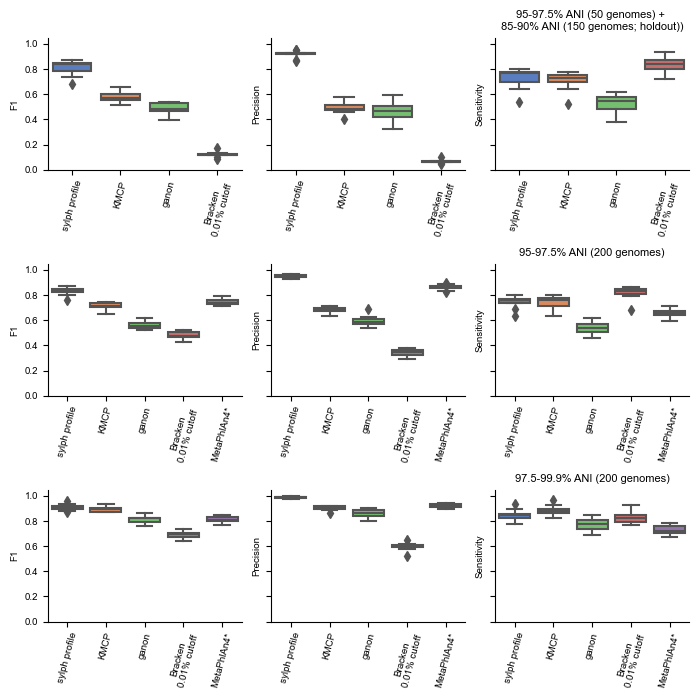

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = 1/2.54  # centimeters in inches\n",
cmap = sns.color_palette("muted")
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.family':'arial'})

fig, axes = plt.subplots(3, 3, figsize=(7, 7), sharey=True)
plt.subplots_adjust(hspace=0.4)

# Define the test setups and metrics
test_setups = ["95-97.5% ANI (50 genomes) + \n85-90% ANI (150 genomes; holdout))", 
               "95-97.5% ANI (200 genomes)",
               "97.5-99.9% ANI (200 genomes)"]
metrics = ['f1', 'precision', 'sensitivity']

y_positions = [1, 0.65, 0.30]

# Loop through the test setups and metrics to fill the grid
for i, setup in enumerate(test_setups):
    if i == 0:
        methods = ['sylph profile', 'KMCP', 'ganon', 'Bracken\n0.01% cutoff']
        stats_l = [sylph_stats, kmcp_stats, ganon_stats, kraken_stats]
    else:
        methods = ['sylph profile', 'KMCP', 'ganon', 'Bracken\n0.01% cutoff', 'MetaPhlAn4*']
        stats_l = [sylph_stats, kmcp_stats, ganon_stats, kraken_stats, metaphlan_stats]
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        
        # Extract the data for this subplot
        data_to_plot = []
        for k, method_stats in enumerate(stats_l):
            #print(method_stats[i])
            method_data = [x[metric] for x in method_stats[i]]
            data_to_plot.append(method_data)
        
        # Create the boxplot with smaller width
        sns.boxplot(data=data_to_plot, ax=ax, palette="muted", width=0.8)
        
        # Add labels
        ax.set_xticklabels(methods)
        ax.set_ylabel(metric.capitalize())

        if j == 2:
            ax.set_title(test_setups[i], fontsize=8.0)
        
        # Remove the top and right borders
        sns.despine(ax=ax)
        ax.tick_params(axis='x', rotation=75)
        #if i != 2:
        #    ax.set_xticks([])
        
    # Add one title per row in the middle
    #fig.text(0.5, y_positions[i], setup, ha="center", va="center", fontsize=9)

# Show the grid of plots
plt.tight_layout()
plt.savefig('figures/ani_r89_benchmark.svg')
plt.show()

/home/jimshawster/mambaforge/envs/taxprof/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jimshawster/mambaforge/envs/taxprof/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jimshawster/mambaforge/envs/taxprof/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jimshawster/mambaforge/envs/taxprof/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

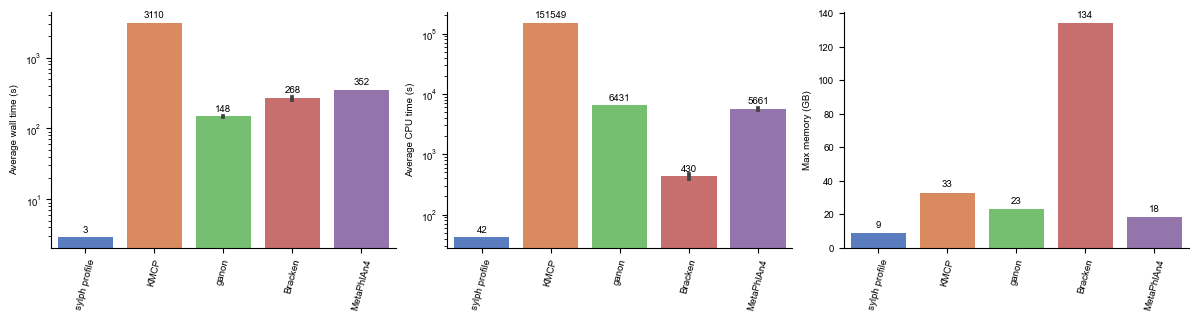

In [20]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize empty lists to store data
time_data = []
cpu_time_data = []
memory_data = []

plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.family':'arial'})

# Function to read and parse benchmark data
def read_benchmark_data(filename, method, num_samples=1):
    with open(filename, 'r') as f:
        lines = f.readlines()
        headers = lines[0].strip().split('\t')
        values = lines[1].strip().split('\t')

        time_index = headers.index('s')
        cpu_time_index = headers.index('cpu_time')
        memory_index = headers.index('max_rss')

        time_data.append({'method': method, 'time': float(values[time_index])/num_samples})
        cpu_time_data.append({'method': method, 'cpu_time': float(values[cpu_time_index])/num_samples})
        memory_data.append({'method': method, 'memory': float(values[memory_index])/1000})

# Loop through each experiment and collect data
for exp in ['species90', 'species96', 'species98']:
    for method in [ 'kmcp', 'ganon', 'kraken', 'metaphlan']:#, 'motus']:
        for iter_file in glob.glob(f'benchmarks/{exp}/{exp}_*.{method}.benchmark'):
            read_benchmark_data(iter_file, method)

# Read sylph data (let's assume you have 30 samples for sylph)
read_benchmark_data('benchmarks/sylph.benchmark', 'sylph', num_samples=30)

# Convert lists of dictionaries to DataFrames
time_df = pd.DataFrame(time_data)
cpu_time_df = pd.DataFrame(cpu_time_data)
memory_df = pd.DataFrame(memory_data)

method_to_label = {
    'ganon': 'ganon',
    'kmcp': 'KMCP',
    'kraken': 'Bracken',
    'sylph': 'sylph profile',
    'metaphlan': 'MetaPhlAn4',
    #'motus': 'motus'
    
}


# Replace the method names in the DataFrames
time_df['method'] = time_df['method'].map(method_to_label)
cpu_time_df['method'] = cpu_time_df['method'].map(method_to_label)
memory_df['method'] = memory_df['method'].map(method_to_label)
# Create subplots

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
palette = sns.color_palette("muted")
ordered_labels = ['sylph profile',  'KMCP', 'ganon','Bracken', 'MetaPhlAn4']#, 'motus']
# Plot the wall time, CPU time and memory
ax1 = sns.barplot(y='time', x='method', log=True, data=time_df, estimator=lambda x: sum(x)/len(x), ax=axes[0], palette=palette, order=ordered_labels)
ax2 = sns.barplot(y='cpu_time', x='method', log=True,  data=cpu_time_df, estimator=lambda x: sum(x)/len(x), ax=axes[1], palette=palette, order=ordered_labels)
ax3 = sns.barplot(x='method', y='memory', data=memory_df, estimator=max, ax=axes[2], palette=palette, order=ordered_labels)

ax1.set(xlabel='', ylabel='Average wall time (s)')
ax2.set(xlabel='', ylabel='Average CPU time (s)')
ax3.set(xlabel='', ylabel='Max memory (GB)')

# Add titles and remove top and right borders
titles = ['Average Wall Time (s)', 'Average CPU Time (s)', 'Max Memory (RSS)']
for ax, title in zip(axes, titles):
    #ax.set_title(title)
    sns.despine(ax=ax)

# Annotate bars with integers
for (k,ax) in enumerate(axes):
    for p in ax.patches:
        if k == 2:
            ax.annotate(f'{round(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height() + 2 ),
                    ha='center', va='bottom')
        else:
            ax.annotate(f'{round(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height() * 1.1 ),
                    ha='center', va='bottom')
    ax.tick_params(axis='x', rotation=75)

#plt.suptitle('Performance Metrics Across All Methods, Samples, and Experiments')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures/ani_profile_benchmark_times.svg')
plt.show()

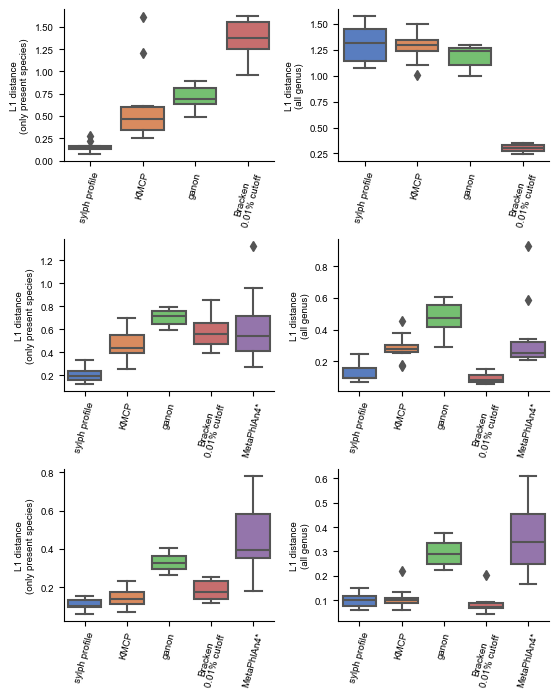

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plot aesthetics
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.family': 'arial'})

# Create the 1-row, 3-column subplot layout
fig, axes = plt.subplots(3, 2, figsize=(7 * 2/3 * 1.2, 7), sharey=False)
plt.subplots_adjust(hspace=0.4)

# Define the test setups
test_setups = ["95-97.5% ANI (50 genomes) + \n85-90% ANI (150 genomes; not present at species-level)", 
               "95-97.5% ANI (200 genomes)",
               "97.5-99.9% ANI (200 genomes)"]

#methods = ['sylph profile', 'KMCP', 'Bracken\n0.01% cutoff']

# Loop through the test setups to fill the grid
for i, setup in enumerate(test_setups):
    #for (j, eval) in enumerate(['l1', 'l1_constrain']):
    for (j, eval) in enumerate(['l1_constrain', 'l1genus']):
        if i == 0:
            methods = ['sylph profile', 'KMCP', 'ganon', 'Bracken\n0.01% cutoff']
            if j == 1:
                stats_l = [[sylph_stats_all,[],[]],
                           [kmcp_stats_all,[],[]], 
                           [ganon_stats_all,[],[]],
                           [kraken_stats_all,[],[]]]
            else:
                stats_l = [sylph_stats, kmcp_stats, ganon_stats, kraken_stats]
        else:
            methods = ['sylph profile', 'KMCP', 'ganon', 'Bracken\n0.01% cutoff', 'MetaPhlAn4*']
            stats_l = [sylph_stats, kmcp_stats, ganon_stats, kraken_stats, metaphlan_stats]
        ax = axes[i][j]
        
        # Extract the data for this subplot
        data_to_plot = []
        for k, method_stats in enumerate(stats_l):
            method_data = [x[eval] for x in method_stats[i]]
            data_to_plot.append(method_data)
        
        # Create the boxplot with smaller width
        sns.boxplot(data=data_to_plot, ax=ax, palette="muted", width=0.8)
        
        # Add labels
        # Two plots: species normalized L1, 
        # Holdout plot: species normalized L1, species true relative L1
        ax.set_xticklabels(methods)
        #if j == 0:
        #    ax.set_title(test_setups[i], fontsize=8.0)
        if j == 1:
            ax.set_ylabel('L1 distance\n(all genus)')
        if j == 0:
            ax.set_ylabel('L1 distance\n(only present species)')
    
        # Remove the top and right borders
        sns.despine(ax=ax)
        ax.tick_params(axis='x', rotation=75)
        
# Show the grid of plots
plt.tight_layout()
plt.savefig('figures/l1_metric_benchmark.svg')
plt.show()




/tmp/ipykernel_165080/887960619.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame([{'Test Setup': setup, 'Method': method, 'Metric': metric, 'Value': value}])], ignore_index=True)
/home/jimshawster/mambaforge/envs/taxprof/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jimshawster/mambaforge/envs/taxprof/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types

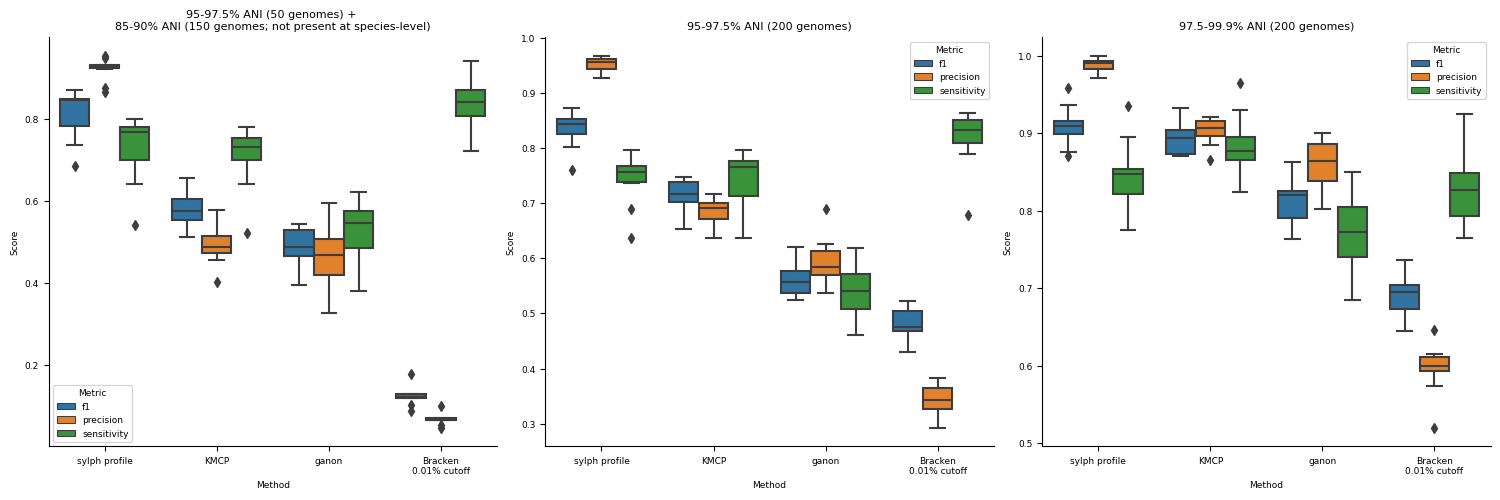

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Your configuration remains the same
cmap = sns.color_palette("muted")
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
#plt.rcParams.update({'font.family':'arial'})

# Define the test setups and metrics
test_setups = ["95-97.5% ANI (50 genomes) + \n85-90% ANI (150 genomes; not present at species-level)", 
               "95-97.5% ANI (200 genomes)",
               "97.5-99.9% ANI (200 genomes)"]
metrics = ['f1', 'precision', 'sensitivity']
methods = ['sylph profile', 'KMCP', 'ganon', 'Bracken\n0.01% cutoff']

# Create an empty DataFrame
df = pd.DataFrame(columns=['Test Setup', 'Method', 'Metric', 'Value'])

# Populate the DataFrame
for i, setup in enumerate(test_setups):
    for method, method_stats in zip(methods, [sylph_stats, kmcp_stats, ganon_stats, kraken_stats]):
        for sample in method_stats[i]:
            for metric in metrics:
                value = sample[metric]
                df = pd.concat([df,pd.DataFrame([{'Test Setup': setup, 'Method': method, 'Metric': metric, 'Value': value}])], ignore_index=True)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    sns.boxplot(x="Method", y="Value", hue="Metric", data=df[df['Test Setup'] == test_setups[i]], ax=ax)
    ax.set_title(test_setups[i], fontsize=8.0)
    ax.set_ylabel('Score')
    sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('figures/ani_r89_benchmark_collapsed.svg')
plt.show()